# Fantasy Football Season Stats

The motivation for this project was to look at the role of the random schedule, and see how that affected our season standings. This involved gathering data about how we did during the season and doing an analysis.

In [1]:
# imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# set
pd.set_option('display.max_columns', None)
sns.set(rc = {'figure.figsize':(8, 4)})

In [2]:
# login info - do I need to hide this?
swid = '0'
s2 = [input yourself]
url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/2022/segments/0/leagues/[league ID]'

# Create Data Frame

First create the data frame with just the weekly and total points, and team identifiers

In [3]:
# get team info
r = requests.get(url, params={"view": "mTeam"}, cookies={'swid': swid, "espn_s2": s2})
json = r.json()
teams_json = json['teams']

# basic stats
ids = []
names = []
wins = []
losses = []
for team in teams_json:
    ids.append(team['id'])
    names.append(team['abbrev'])
    wins.append(team['record']['overall']['wins'])
    losses.append(team['record']['overall']['losses'])

# create df    
teams_df = pd.DataFrame({'id': ids, 'name': names, 'wins': wins, 'losses': losses})
teams_df

,id,name,wins,losses
0,1,MAZE,6,5
1,2,USSR,6,5
2,3,JEFF,6,5
3,4,BDE,6,5
4,5,WTF,2,9
5,6,PIC,7,4
6,7,BRAT,6,5
7,8,CDN,5,6
8,10,Bamf,5,6
9,11,BARD,6,5


# Populate With Weekly and Total Score

In [4]:
# get weekly game stats
r = requests.get(url, params={"view": "mScoreboard"}, cookies={'swid': swid, "espn_s2": s2})
json = r.json()

# get schedule up until this week
weeks_played = teams_df['wins'][0] + teams_df['losses'][0] # could this go wrong?
games_played = weeks_played * 5
schedule_current = json['schedule'][:games_played]

# add weekly points to columns
weekly_columns = []
for w in range(weeks_played):
    # create column
    column_name = f'week {w+1} points'
    teams_df[column_name] = np.nan
    weekly_columns.append(column_name)
    
    game_indices = np.linspace(5*w, 5*w+4, 5)
    for i in game_indices:
        i = int(i)
        game = schedule_current[i]
        away = game['away']
        away_id = away['teamId']
        away_points = away['totalPoints']
        teams_df.loc[teams_df['id'] == away_id, column_name] = away_points
    
        home = game['home']
        home_id = home['teamId']
        home_points = home['totalPoints']
        teams_df.loc[teams_df['id'] == home_id, column_name] = home_points

# get total score and standard deviation
just_points = teams_df[weekly_columns]
teams_df['total points'] = just_points.sum(axis=1)
teams_df['average ppg'] = teams_df['total points'] / weeks_played
teams_df['std points'] = just_points.std(axis=1)
    
teams_df

,id,name,wins,losses,week 1 points,week 2 points,week 3 points,week 4 points,week 5 points,week 6 points,week 7 points,week 8 points,week 9 points,week 10 points,week 11 points,total points,average ppg,std points
0,1,MAZE,6,5,96.00,106.26,109.36,160.98,113.16,136.70,115.50,144.92,130.50,123.08,132.78,1369.24,124.476364,18.939214
1,2,USSR,6,5,144.90,114.50,116.08,115.36,131.08,76.52,96.02,155.42,127.04,95.54,68.36,1240.82,112.801818,26.971541
2,3,JEFF,6,5,148.56,133.46,134.68,135.60,131.52,96.92,102.42,128.68,100.10,123.70,134.14,1369.78,124.525455,16.999605
3,4,BDE,6,5,114.32,125.26,99.70,109.78,129.68,101.20,168.84,115.28,131.64,120.28,103.60,1319.58,119.961818,19.585063
4,5,WTF,2,9,113.02,123.58,107.26,63.96,60.62,80.32,81.20,110.78,38.00,103.30,63.26,945.30,85.936364,27.411556
5,6,PIC,7,4,137.48,204.88,115.80,117.92,140.56,147.86,76.42,147.58,94.20,123.80,105.68,1412.18,128.380000,33.916915
6,7,BRAT,6,5,114.56,148.58,94.84,136.62,100.86,126.86,111.94,102.44,123.16,100.08,77.40,1237.34,112.485455,20.353811
7,8,CDN,5,6,132.82,161.52,100.62,119.16,92.76,98.40,131.80,96.12,71.22,100.80,105.36,1210.58,110.052727,24.610267
8,10,Bamf,5,6,95.38,109.20,92.72,169.50,116.94,103.82,126.10,168.58,169.38,110.10,154.44,1416.16,128.741818,30.769319
9,11,BARD,6,5,144.52,100.02,123.00,141.06,184.28,93.20,94.62,134.30,113.52,127.20,117.70,1373.42,124.856364,26.441333


# Convert Score into Rank

In [5]:
# use argsort to turn points into rank
def points_to_rank(column):
    return column.argsort().argsort()
    
# apply function
ranks_df = teams_df[weekly_columns].apply(points_to_rank, axis=0)

# rename columns
column_mapper = {}
weekly_rank_columns = []
for column in ranks_df.columns:
    column_mapper[column] = column[:7]+'rank'
    weekly_rank_columns.append(column[:7]+'rank')
ranks_df.rename(mapper=column_mapper, axis=1, inplace=True)

# concatenate
teams_df = pd.concat([teams_df, ranks_df], axis=1)

# get total rank
just_ranks = teams_df[ranks_df.columns]
teams_df['total rank'] = just_ranks.sum(axis=1)

# Some Plots

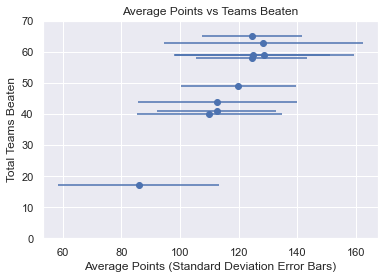

In [6]:
# set
sns.set(rc={'figure.figsize':(8,5)})

# scatter
plt.errorbar(x=teams_df['average ppg'], y=teams_df['total rank'], xerr=teams_df['std points'], fmt='o')
plt.title('Average Points vs Teams Beaten')
plt.xlabel('Average Points (Standard Deviation Error Bars)')
plt.ylabel('Total Teams Beaten')
plt.ylim(0,70)
plt.show()

Here, teams beaten the total number of teams you outscored each week through the season. For example, if you had the highest score one week, that would add 9 to the total. This plotted against average points scored each week, with standard deviation error bars. We can see the general trend of higher scoring teams having beaten more teams.

C:\Users\12486\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


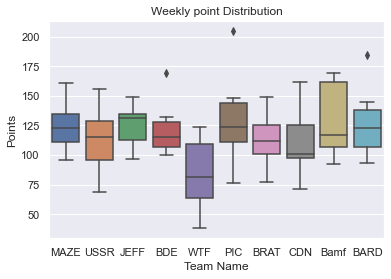

In [7]:
# boxplots of points per week
weekly_rows = np.transpose(teams_df[weekly_columns].values)
weekly_team_results_df = pd.DataFrame(data=weekly_rows, columns=names)
weekly_team_results_df
sns.boxplot(data=weekly_team_results_df)
plt.title('Weekly point Distribution')
plt.xlabel('Team Name')
plt.ylabel('Points')
plt.show()

Here is a simple boxplot showing the distribution of weekly points scored for each team.

# The Role of Schedule Luck

First I'm going to calculate luck based on a totally random "schedule". As in, each player selects one other each week to compare to. This doesn't actually build schedules, it just goes off your probability of winning based on your rank that week. This is the most basic version and could be furthered by building actual schedules.

In [8]:
# get probability of winning each number of games
def prob_win(ranks):
    # ranks is a list
    n_weeks = len(ranks)
    iters = int(1e5)
    p_win = np.array(ranks) / 9 # maybe replace 9 with len(teams) - 1
    win_distribution = []
    for _ in range(iters):
        wins = 0
        for g in p_win:
            s = np.random.uniform()
            if s < g:
                wins += 1
        win_distribution.append(wins)
    values, counts = np.unique(win_distribution, return_counts=True)
    probabilities = counts / iters
    if len(probabilities) != n_weeks+1:
        new_probs = []
        index = 0
        for i in range(n_weeks+1):
            if i in values:
                new_probs.append(probabilities[index])
                index += 1
            else:
                new_probs.append(0)
        probabilities = new_probs
            
    
    return probabilities

# make the columns
prob_win_games = teams_df.apply(lambda t: prob_win([t[w] for w in weekly_rank_columns]), axis=1, result_type='expand')

# rename mapper
rename_map = {}
for i in prob_win_games.columns:
    rename_map[i] = f'prob {i} wins'
rename_map

# rename
prob_win_games.rename(mapper=rename_map, inplace=True, axis=1)
prob_win_games

teams_df = pd.concat([teams_df, prob_win_games], axis=1)

In [9]:
# get luck from this - integral of win distribution up to your number of wins
def schedule_luck(probwinlist):
    wins = probwinlist[-1]
    probs = probwinlist[:-1]
    less_than = 0
    equals = 0
    greater_than = 0
    for i in range(len(probs)):
        if i < wins:
            less_than += probs[i]
        elif i == wins:
            equals += probs[i]
        elif i > wins:
            greater_than += probs[i]
             
    return [less_than, equals, greater_than]

# calculate luck
luck_columns = [f'prob {w} wins' for w in range(weeks_played+1)]
luck_columns.append('wins')
#luck_columns = ['prob 0 wins', 'prob 1 wins', 'prob 2 wins', 'prob 3 wins', 'prob 4 wins', 'wins']
luck_columns = teams_df.apply(lambda t: schedule_luck([t[w] for w in luck_columns]), axis=1,
                                          result_type='expand')

# rename columns
rename_map = {0: 'p worse', 1: 'p same', 2: 'p better'}
luck_columns.rename(mapper=rename_map, inplace=True, axis=1)
teams_df = pd.concat([teams_df, luck_columns], axis=1)

In [10]:
# export as csv if you want
#teams_df.to_csv('data/myleague.csv')
teams_df

,id,name,wins,losses,week 1 points,week 2 points,week 3 points,week 4 points,week 5 points,week 6 points,week 7 points,week 8 points,week 9 points,week 10 points,week 11 points,total points,average ppg,std points,week 1 rank,week 2 rank,week 3 rank,week 4 rank,week 5 rank,week 6 rank,week 7 rank,week 8 rank,week 9 rank,week 10rank,week 11rank,total rank,prob 0 wins,prob 1 wins,prob 2 wins,prob 3 wins,prob 4 wins,prob 5 wins,prob 6 wins,prob 7 wins,prob 8 wins,prob 9 wins,prob 10 wins,prob 11 wins,p worse,p same,p better
0,1,MAZE,6,5,96.00,106.26,109.36,160.98,113.16,136.70,115.50,144.92,130.50,123.08,132.78,1369.24,124.476364,18.939214,1,1,5,8,3,8,6,6,7,6,7,58,0.00001,0.00016,0.00207,0.01467,0.06248,0.16364,0.26636,0.26991,0.16380,0.05013,0.00641,0.00036,0.24303,0.26636,0.49061
1,2,USSR,6,5,144.90,114.50,116.08,115.36,131.08,76.52,96.02,155.42,127.04,95.54,68.36,1240.82,112.801818,26.971541,8,3,7,2,6,0,3,8,6,0,1,44,0.00006,0.00209,0.02342,0.10122,0.24551,0.32027,0.21663,0.07683,0.01320,0.00077,0.00000,0.00000,0.69257,0.21663,0.09080
2,3,JEFF,6,5,148.56,133.46,134.68,135.60,131.52,96.92,102.42,128.68,100.10,123.70,134.14,1369.78,124.525455,16.999605,9,6,9,5,7,3,4,4,3,7,8,65,0.00000,0.00000,0.00011,0.00266,0.01890,0.07880,0.19499,0.28353,0.24934,0.12995,0.03719,0.00453,0.10047,0.19499,0.70454
3,4,BDE,6,5,114.32,125.26,99.70,109.78,129.68,101.20,168.84,115.28,131.64,120.28,103.60,1319.58,119.961818,19.585063,3,5,2,1,5,5,9,3,8,5,3,49,0.00000,0.00089,0.01346,0.06686,0.17230,0.26503,0.25540,0.15342,0.05753,0.01337,0.00167,0.00007,0.51854,0.25540,0.22606
4,5,WTF,2,9,113.02,123.58,107.26,63.96,60.62,80.32,81.20,110.78,38.00,103.30,63.26,945.30,85.936364,27.411556,2,4,4,0,0,1,1,2,0,3,0,17,0.09787,0.28955,0.33458,0.19997,0.06568,0.01152,0.00081,0.00002,0.00000,0.00000,0.00000,0.00000,0.38742,0.33458,0.27800
5,6,PIC,7,4,137.48,204.88,115.80,117.92,140.56,147.86,76.42,147.58,94.20,123.80,105.68,1412.18,128.380000,33.916915,6,9,6,3,8,9,0,7,2,8,5,63,0.00000,0.00000,0.00007,0.00166,0.01781,0.08471,0.22362,0.32454,0.24837,0.08802,0.01120,0.00000,0.32787,0.32454,0.34759
6,7,BRAT,6,5,114.56,148.58,94.84,136.62,100.86,126.86,111.94,102.44,123.16,100.08,77.40,1237.34,112.485455,20.353811,4,7,1,6,2,7,5,1,5,1,2,41,0.00077,0.01066,0.05369,0.15815,0.26254,0.26877,0.16607,0.06314,0.01437,0.00170,0.00013,0.00001,0.75458,0.16607,0.07935
7,8,CDN,5,6,132.82,161.52,100.62,119.16,92.76,98.40,131.80,96.12,71.22,100.80,105.36,1210.58,110.052727,24.610267,5,8,3,4,1,4,8,0,1,2,4,40,0.00032,0.00815,0.05611,0.17563,0.28381,0.26653,0.14940,0.04986,0.00932,0.00084,0.00003,0.00000,0.52402,0.26653,0.20945
8,10,Bamf,5,6,95.38,109.20,92.72,169.50,116.94,103.82,126.10,168.58,169.38,110.10,154.44,1416.16,128.741818,30.769319,0,2,0,9,4,6,7,9,9,4,9,59,0.00000,0.00000,0.00000,0.00000,0.01792,0.13181,0.32711,0.34546,0.15460,0.02310,0.00000,0.00000,0.01792,0.13181,0.85027
9,11,BARD,6,5,144.52,100.02,123.00,141.06,184.28,93.20,94.62,134.30,113.52,127.20,117.70,1373.42,124.856364,26.441333,7,0,8,7,9,2,2,5,4,9,6,59,0.00000,0.00000,0.00037,0.00571,0.03927,0.14511,0.28433,0.30462,0.17109,0.04506,0.00444,0.00000,0.19046,0.28433,0.52521


In [11]:
# not actually a hist #oops
def win_hist(weekprobs):
    name = weekprobs[0]
    wins = weekprobs[1]
    probs = weekprobs[2:]
    weeks = len(probs)
    x = range(weeks)
    heights = probs
    #plt.bar(x, heights, width=1.0, alpha=0.5, label=name, edgecolor='k')
    plt.scatter(wins, probs[wins])
    plt.plot(x, heights, label=name)
    #sns.displot(heights, x=x, kind='kde')

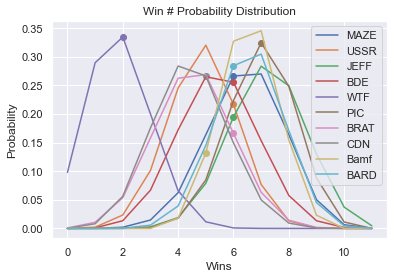

In [12]:
name = ['name']
wins = ['wins']
luck_columns = [f'prob {w} wins' for w in range(weeks_played+1)]
teams_df.apply(lambda t: win_hist([t[w] for w in name+wins+luck_columns]), axis=1,
                                          result_type='expand')

plt.title('Win # Probability Distribution')
plt.xlabel('Wins')
plt.ylabel('Probability')

plt.legend()
plt.show()

Finally, we have the distribution I have been getting at. Given a totally randomized schedule, this shows the probability that each team has x amount of wins. Also, plotted is the actual number of wins each team has. Where along the curve you lie roughly determines how lucky you have been. My team is the one labled 'JEFF', so you can imagine why I was motivated to make this plot :)